First figure of the manuscript, showing "broadband" timescales. 
- Brain maps of timescales across wake and sleep stages.
- Overall timescales changes in wake and sleep across all brain areas.
- Correlation sizes of timescales with T1w/T2w score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore, bootstrap, ttest_rel, linregress
import matplotlib.pyplot as plt
import mne
import nibabel as nib

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["W", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "spearman"

# Paths
data_path = Path("F:\\MNIOpen")
tau_path = data_path.joinpath("Results", "timescales_broadband")
fig_path = data_path.joinpath("Figures", "Fig_broadband")
fig_path.mkdir(exist_ok=True, parents=True)
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Average ACFs across wake and sleep 

Comparison of average ACF curves across wake and sleep stages.

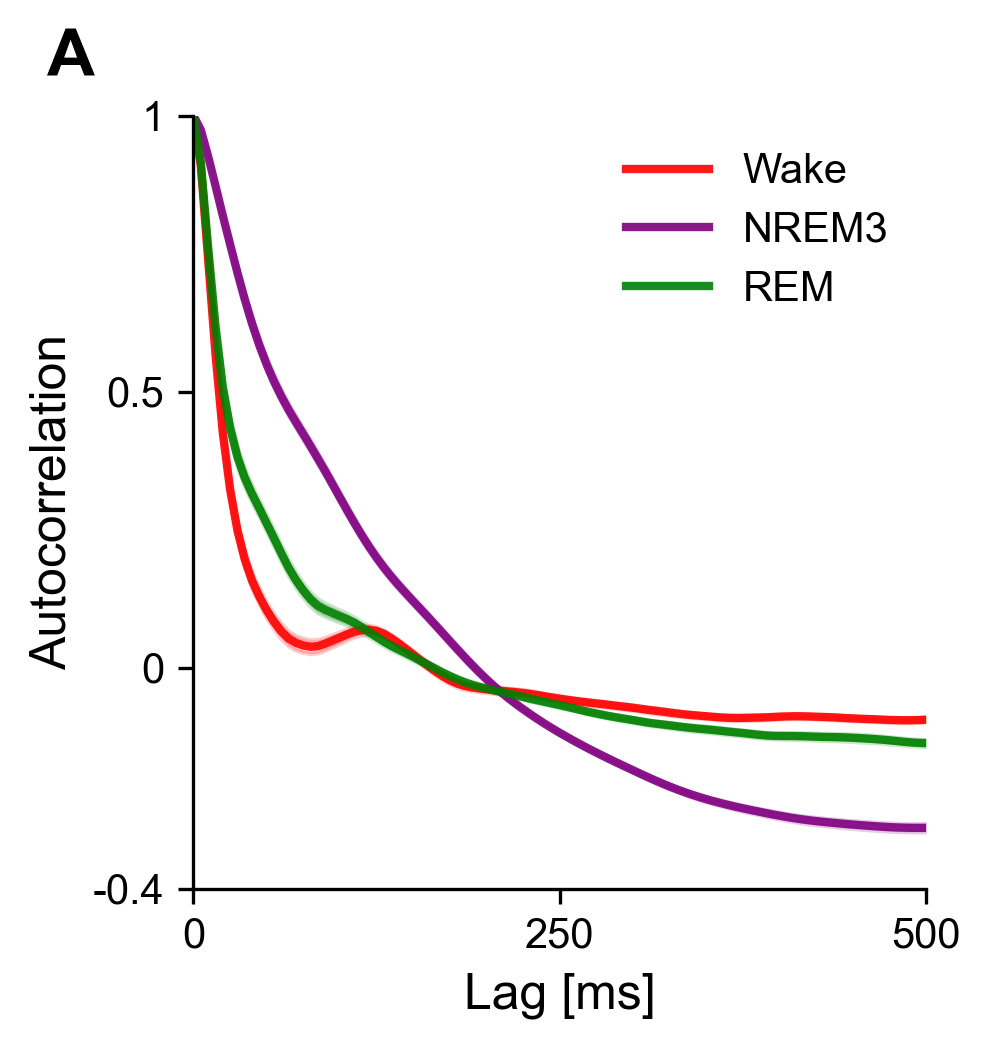

In [53]:
# Set up the figure
fig, ax = plt.subplots(figsize=plots._get_figsize_inches((8., 8.5)), dpi=300)

# Find patients subfolders
pats = [pat.stem for pat in tau_path.joinpath("Pats").glob("*") if pat.is_dir()]

# Loop through stages
for stage in stages:

    # Store ACF for all patients
    acf_pats_stage = []
    lags = None

    # Loop through patients
    for pat in pats:
        pat_dir = tau_path.joinpath("Pats").joinpath(pat)
        # Load ACF
        try:
            with open(
                pat_dir.joinpath("ACF/" + pat + "_" + stage.lower() + ".pkl"),
                "rb",
            ) as f:
                acf_pat_stage = pickle.load(f)
        except FileNotFoundError:
            continue

        # Append channels
        acf_pats_stage.append(acf_pat_stage["acf"].mean(axis=0).mean(axis=0))
        if lags is None:
            lags = acf_pat_stage["lags"]

    # Average across patients
    N_pats = len(acf_pats_stage)
    acf_pats_stage = np.stack(acf_pats_stage)
    acf_stage_avg = acf_pats_stage.mean(axis=0)
    acf_stage_se = acf_pats_stage.std(axis=0) / np.sqrt(N_pats)

    # Figure ACF
    ax.plot(
        lags * 1000,
        acf_stage_avg,
        c=stage_colors[stage],
        label=title_dict[stage],
        lw=2,
        alpha=0.9,
    )
    ax.fill_between(
        lags * 1000,
        acf_stage_avg - acf_stage_se,
        acf_stage_avg + acf_stage_se,
        color=stage_colors[stage],
        alpha=0.2,
    )
# Plot parameters
ax.set_xlim(0, 500)
ax.set_xticks([0, 250, 500], labels=[0, 250, 500], fontsize=plots.fsize.TICK_SIZE)
ax.set_xlabel("Lag [ms]", fontsize=plots.fsize.LABEL_SIZE)
ax.set_ylim(-0.4, 1)
ax.set_yticks(
    [-0.4, 0, 0.5, 1], labels=[-0.4, 0, 0.5, 1], fontsize=plots.fsize.TICK_SIZE
)
ax.set_ylabel("Autocorrelation", fontsize=plots.fsize.LABEL_SIZE)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, fontsize=plots.fsize.TICK_SIZE, loc="upper right")

# Annotate panel
ax.text(-0.2, 1.05, "A", transform=ax.transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"ACF_average.svg"))
plt.show()

### B) Average increase of tau during sleep

Slope plot with averaged difference of timescales between wake and sleep stages across all areas of the parcellation.

diff W - N3 : 105.41973299150608 ci [102.49626721472194, 108.21501946842473] pval: 1.242049786973763e-134
diff W - R : 15.514656941391339 ci [13.534613170982784, 17.669220518510073] pval: 4.364414538150435e-32


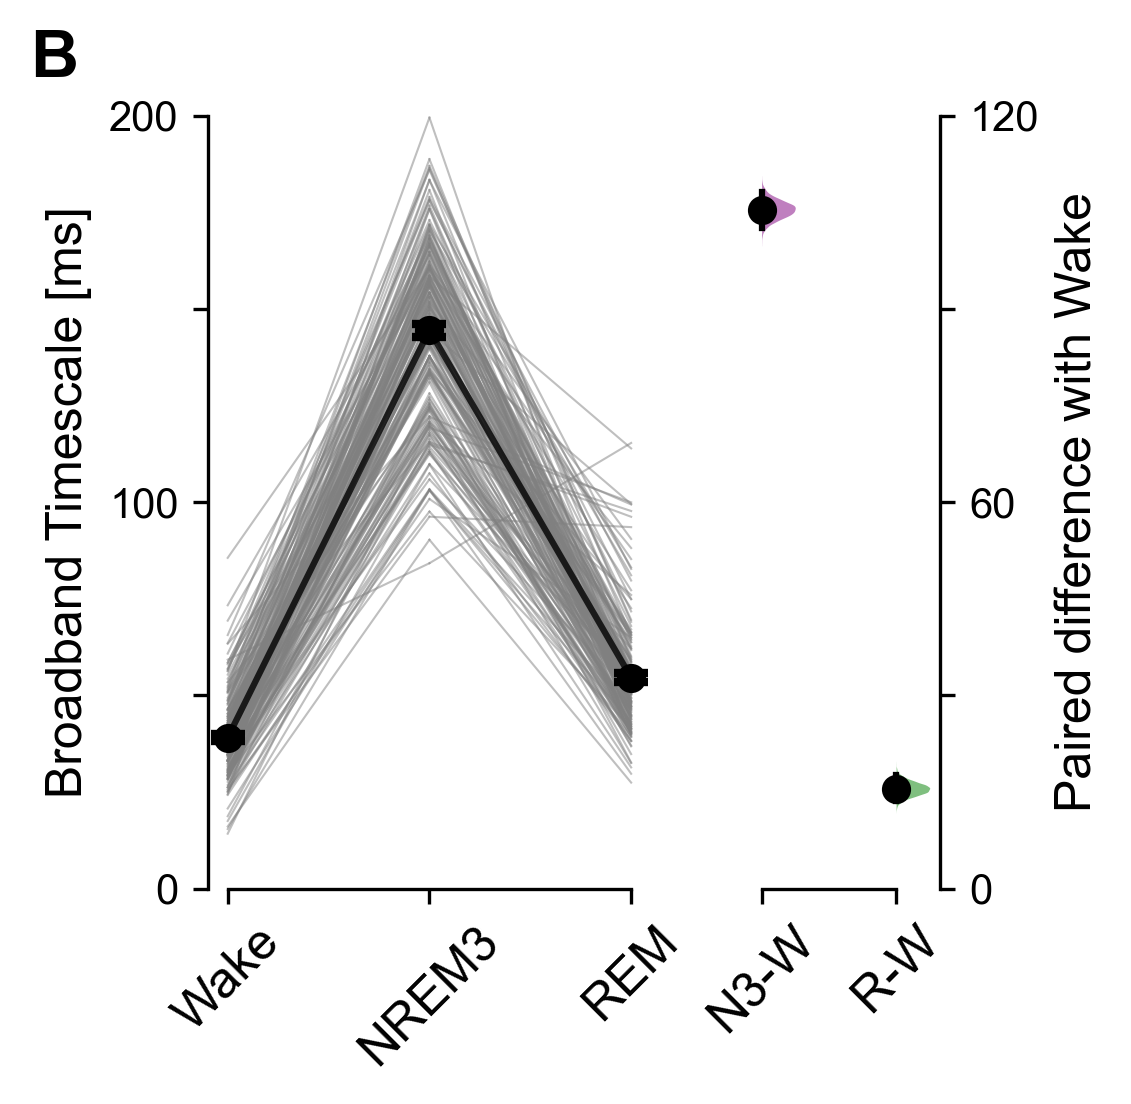

In [23]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_timescales_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8., 8.5)),
    width_ratios=[2, 1],
    dpi=300,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_ylabel("Broadband Timescale [ms]", fontsize=plots.fsize.LABEL_SIZE)
axs[0].set_ylim(0, 200)
axs[0].set_yticks(
    [0, 50, 100, 150, 200],
    labels=[0, "", 100, "", 200],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[0].set_xticks(
    range(len(stages)),
    [title_dict[stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[0], s_bounds={"bottom": (0, 2)})


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )
    print("diff W -", stage, ":", avg, "ci", list(res_boot.confidence_interval), "pval:", pval)
    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(0, 120)
axs[1].set_yticks(
    [0, 30, 60, 90, 120],
    labels=[0, "", 60, "", 120],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].set_xticks(
    range(len(stages) - 1),
    [stage + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[1], s_inv=["top", "left"], s_bounds={"bottom": (0, 1)})

# Annotate panel
axs[0].text(-0.4, 1.05, "B", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_change_stages.svg"))
plt.show()

% channels increasing in NREM3:

In [22]:
df_timescales_stages["R"][df_timescales_stages["N3"] < df_timescales_stages["R"]].dropna()

,0
PreS,115.31629


### C) Plot of parcellated brain areas

Plot absolute values and differences between stages of timescales in the HCP_MMP parcellation.

In [6]:
minmax_stages = {"W": (20, 60), "N2": (60, 110), "N3": (100, 180), "R": (30, 100)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_timescales_stages[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="Timescale [ms]",
        cbar_format="0f",
    )

    if stage == "W":
        # Annotate panel
        ax.text(-0.2, 1.05, "C", transform=ax.transAxes, size=16, weight='bold')

    fig.savefig(
        fig_path.joinpath(f"tau_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

: 

Maps of differences

In [34]:
# Differences
df_plot_W_N3 = df_timescales_stages["N3"] - df_timescales_stages["W"]  # [20, 85]
df_plot_W_R = df_timescales_stages["R"] - df_timescales_stages["W"]  # [-5, 30]

# NREM3 figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(70, 140),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_N3-W.svg"), format="svg", transparent=True)
plt.close(fig)


# REM figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(-10, 60),
    zero_center=False,
    title="REM - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_R-W.svg"), format="svg", transparent=True)
plt.close(fig)

Lower values:

In [33]:
df_timescales_stages["N3"].sort_values("0").head(15)

,0
PreS,84.196859
6d,90.272574
V7,96.230261
33pr,97.558719
V6,100.821279
V3A,103.047631
6mp,103.148537
FEF,103.209256
PEF,103.343076
LBelt,105.879354


### D) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation (for spin permutation):

In [4]:
df_struct = pd.read_csv(data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0)

In [6]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_timescales_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


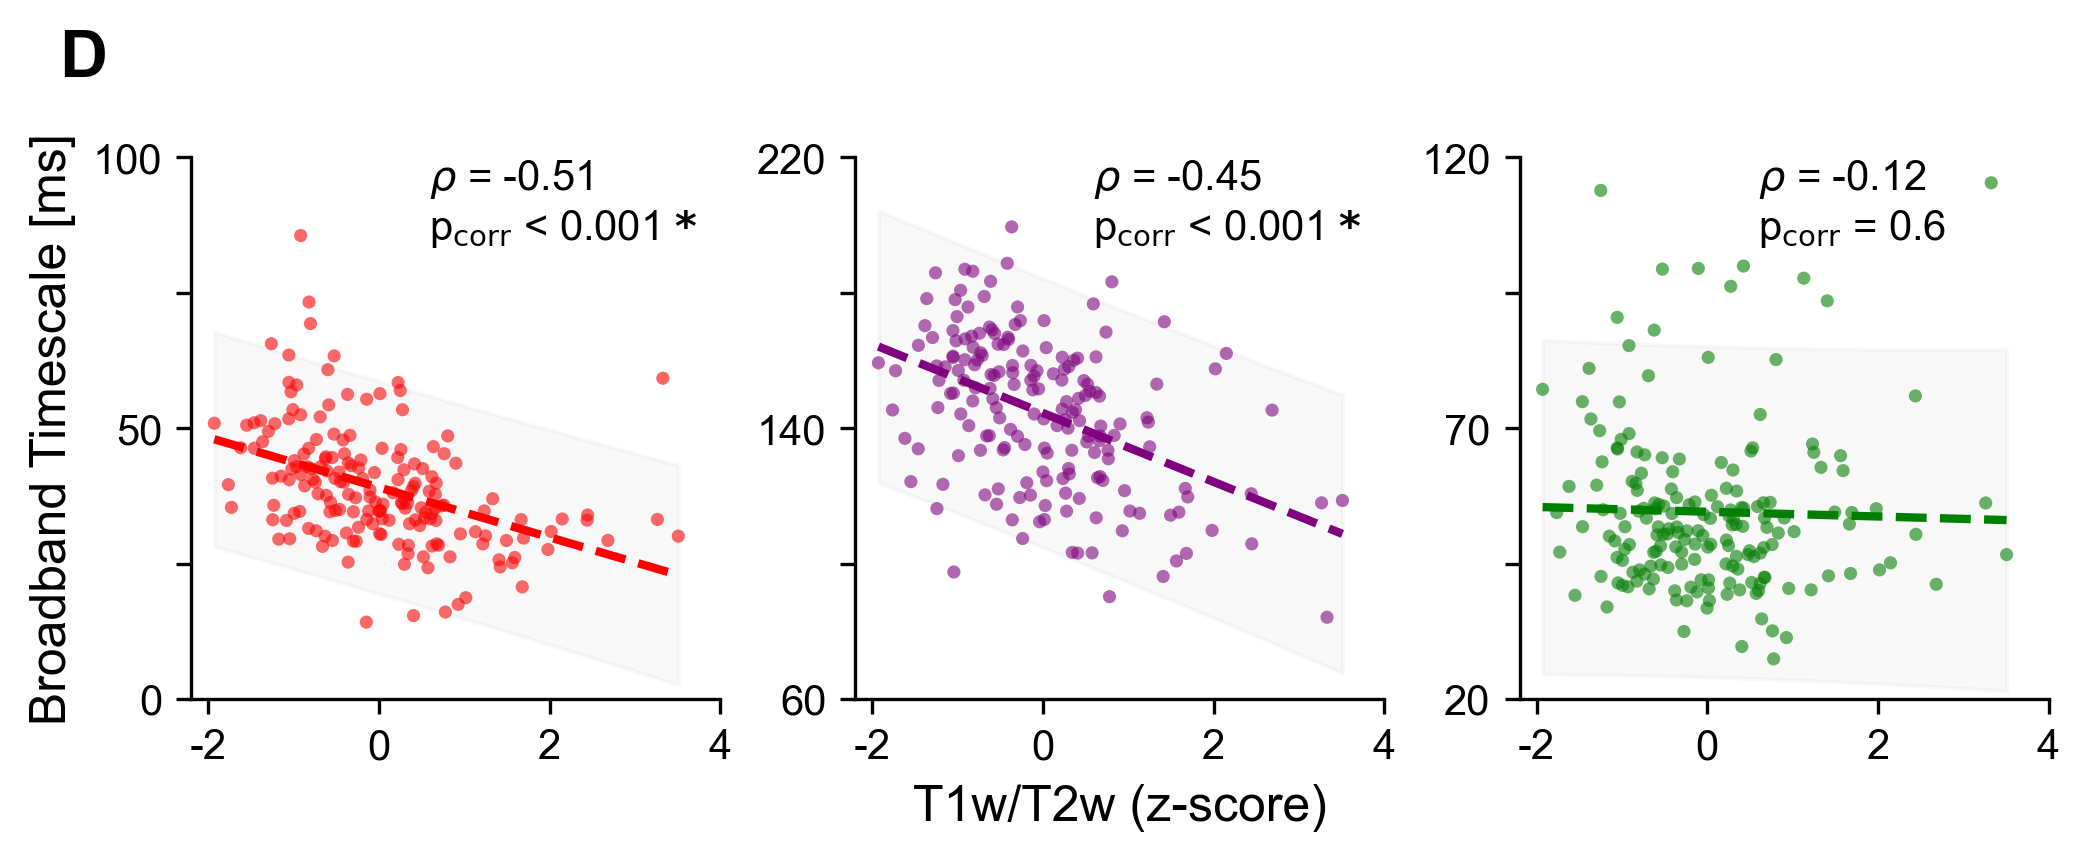

In [7]:
xlabel = "T1w/T2w (z-score)"
ylabel = "Broadband Timescale [ms]"
xlims = (-2.2, 4)
xticks = [-2, 0, 2, 4]
xtick_labels = [-2, 0, 2, 4]
ylims_stages = {"W": (0, 100), "N2": (45, 125), "N3": (60, 220), "R": (20, 120)}
yticks = (
    np.arange(0, 101, 25),
    np.arange(60, 221, 40),
    np.arange(20, 121, 25)
    )
ytick_labels = (
    [0, "", 50, "", 100],
    [60, "", 140, "", 220],
    [20, "", 70, "", 120]
    )

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.4, 7)), dpi=300, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=10,
        xy_annot=(0.45, 0.85),
        color=stage_colors[stage],
        xlabel="",
        ylabel="",
        xlims=xlims,
        ylims=ylims_stages[stage],
    )
    
    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)
    plots._format_spines(axs[i]) #, s_bounds={"bottom": (-2, 4), "left": ylims_stages[stage]})

# Plot customization
axs[0].set_ylabel(ylabel, fontsize=plots.fsize.LABEL_SIZE)
axs[1].set_xlabel(xlabel, fontsize=plots.fsize.LABEL_SIZE)

# Annotate panel
axs[0].text(-0.25, 1.15, "D", transform=axs[0].transAxes, size=16, weight='bold')

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))
plt.show()

### S0) Correlation between timescales in different stages

W N3
LinregressResult(slope=1.0232370582419876, intercept=104.511476246753, rvalue=0.49635923465817644, pvalue=1.380958126054808e-12, stderr=0.13413698014948572, intercept_stderr=5.441826357266861)


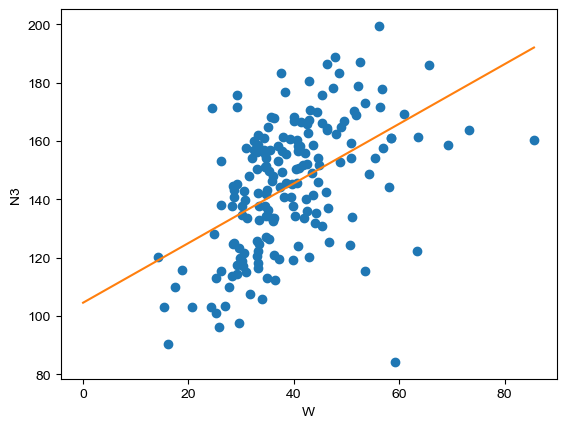

W R
LinregressResult(slope=0.6321169261595024, intercept=29.893941944532145, rvalue=0.4476921366390601, pvalue=2.9532831955667737e-10, stderr=0.09463170674626135, intercept_stderr=3.8391300850150207)


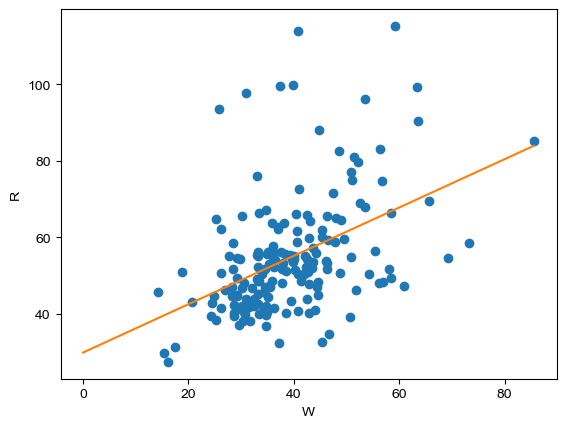

N3 R
LinregressResult(slope=0.10193944872319943, intercept=39.87032793950707, rvalue=0.1488347977706, pvalue=0.046147985811134704, stderr=0.05076489810161081, intercept_stderr=7.423479803505644)


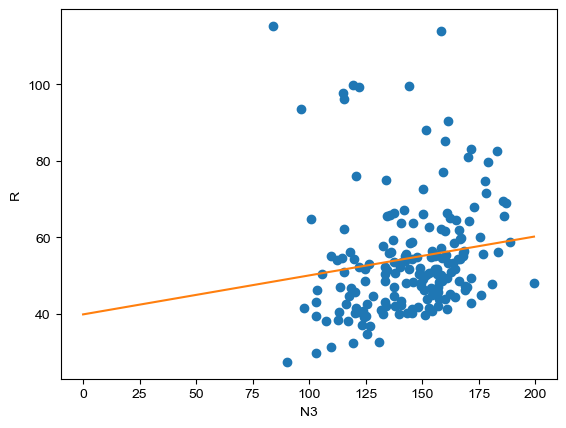

In [8]:
from scipy import stats

for s1, s2 in zip(["W", "W", "N3"], ["N3", "R", "R"]):
    print(s1, s2)
    x = df_timescales_stages[s1].to_numpy().squeeze()
    y = df_timescales_stages[s2].to_numpy().squeeze()
    plt.plot(x, y, "o")
    res = stats.linregress(x, y)
    print(res)
    x_plot = np.linspace(0, x.max(), 100)
    plt.plot(x_plot, res.intercept + res.slope * x_plot)
    plt.xlabel(s1)
    plt.ylabel(s2)
    plt.show()

### S1) Correlation with Gao values

In [8]:
df_Gao = pd.read_csv(data_path.joinpath("Gao2020", "df_tau_avg.csv"), index_col=0)
df_Gao.head()

,tau,logtau
V1,17.369645,1.239791
MST,14.266527,1.154318
V6,14.733831,1.168316
V2,18.599167,1.269493
V3,17.063109,1.232058


Generating 1000 permutations...


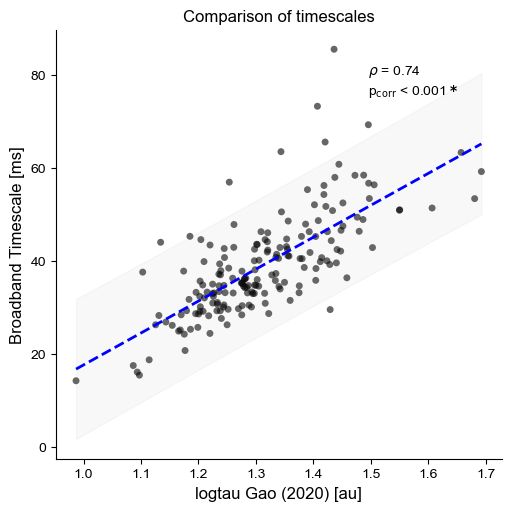

In [10]:
x = df_Gao["logtau"].to_numpy()
y = df_timescales_stages["W"].to_numpy().squeeze()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
ax = plots.plot_corr(
    ax,
    x,
    y,
    rho,
    p_corr,
    color_line="b",
    figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
    markersize=25,
    title=f"Comparison of timescales",
    xlabel="logtau Gao (2020) [au]",
    ylabel="Broadband Timescale [ms]",
)
# ax.set_xlabel("Broadband Timescale [ms]")
# ax.set_ylabel("Gamma Timescale [ms]")

plt.show()